LinkNet 是一种针对实时语义分割任务设计的深度学习模型，于2017年在CVPR（计算机视觉与模式识别会议）上提出（论文标题：《LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation》）。其核心目标是在保证分割精度的同时，大幅提升模型的运行速度，使其能够适配移动设备等资源受限的场景。


### **LinkNet 的核心结构与设计思路**
LinkNet 采用经典的 **Encoder-Decoder（编码器-解码器）** 架构，整体设计借鉴了 U-Net 的“跳跃连接”思想，但在连接方式和轻量化设计上进行了优化，具体结构如下：

#### 1. **Encoder（编码器）**
- **基础网络**：采用轻量化的 ResNet18 作为编码器主干（也可扩展为 ResNet34 等），通过多次下采样（卷积+池化）提取输入图像的多尺度特征。与 U-Net 相比，ResNet18 的参数量更小，计算效率更高。
- **功能**：将输入图像（如 3×H×W）逐步压缩为低分辨率、高语义的特征图（如 512×H/32×W/32），捕捉图像的全局上下文信息。

#### 2. **Decoder（解码器）**
- **核心目标**：将编码器输出的低分辨率特征图逐步上采样，恢复到与输入图像相同的分辨率，最终生成分割掩码（每个像素对应一个类别）。
- **创新的跳跃连接**：  
  与 U-Net 直接拼接编码器不同阶段的特征图不同，LinkNet 设计了更简洁的“链接”方式：  
  - 编码器每个阶段的 **输入特征** 会通过一个 1×1 卷积（降维）后，直接传递给解码器对应阶段的 **输入**，帮助解码器更好地恢复空间细节（如边缘、纹理）。  
  - 这种连接方式减少了特征融合的计算量，同时保留了关键的低层级空间信息。
- **上采样方式**：通过转置卷积（Transposed Convolution）实现特征图的放大，逐步恢复分辨率。

#### 3. **最终输出层**
- 解码器最后一层通过卷积操作将特征图映射到目标类别数（如城市街景分割中的“道路、建筑、行人”等），再通过 Softmax 或 Sigmoid 函数得到每个像素的类别概率。


### **LinkNet 的关键优势**
1. **高效性（实时性）**：  
   由于采用 ResNet18 作为编码器，且简化了跳跃连接的计算，LinkNet 的参数量和计算量远小于 U-Net 等模型，能够在普通 GPU 甚至移动设备上实现实时推理（如 30+ FPS）。
   
2. **精度与速度的平衡**：  
   尽管模型轻量化，但其通过保留编码器的输入特征作为跳跃连接，仍能在分割精度上接近传统 U-Net，尤其在边缘细节恢复上表现较好。

3. **适用于资源受限场景**：  
   设计初衷是为了在移动设备（如手机、无人机）上部署，因此在嵌入式系统、实时监控等对速度要求高的任务中具有优势。


### **LinkNet 的应用场景**
LinkNet 主要用于 **实时语义分割任务**，典型场景包括：
- 自动驾驶中的道路分割（实时识别车道线、行人、障碍物）；
- 无人机航拍图像分割（快速标注地形、建筑）；
- 医学影像实时分割（如术中器官边缘检测）；
- 视频监控中的目标区域分割（如人流统计、异常区域标记）。


### **与其他分割模型的对比**
| 模型       | 参数量   | 推理速度（FPS） | 精度（以 Cityscapes 为例） | 适用场景               |
|------------|----------|-----------------|--------------------------|------------------------|
| U-Net      | 较大（~31M） | 较慢（<10）     | 较高                      | 高精度场景（如医学影像） |
| LinkNet    | 较小（~11M） | 较快（>30）     | 中等（接近 U-Net）        | 实时场景（如自动驾驶） |
| DeepLab v3 | 较大（~40M） | 中等（~20）     | 高                        | 兼顾精度与速度         |


### **总结**
LinkNet 是一种为实时语义分割设计的轻量化模型，通过优化编码器-解码器结构和跳跃连接，在保证一定分割精度的同时，大幅提升了运行速度，尤其适合资源受限的移动端或实时应用场景。其设计思路对后续轻量化分割模型（如 MobileNet + 分割头）也有一定启发。

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils import data  
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision
from torchvision import transforms
import os
import glob 
from PIL import Image

## 创建dataset和dataloader 

In [2]:
all_pics = glob.glob('HKdataset/HKdataset/training/*.png')
all_pics[:5]

['HKdataset/HKdataset/training\\00001.png',
 'HKdataset/HKdataset/training\\00001_matte.png',
 'HKdataset/HKdataset/training\\00002.png',
 'HKdataset/HKdataset/training\\00002_matte.png',
 'HKdataset/HKdataset/training\\00003.png']

In [3]:
imgs = [pic for pic in all_pics if 'matte' not in pic]
imgs[:5]

['HKdataset/HKdataset/training\\00001.png',
 'HKdataset/HKdataset/training\\00002.png',
 'HKdataset/HKdataset/training\\00003.png',
 'HKdataset/HKdataset/training\\00004.png',
 'HKdataset/HKdataset/training\\00005.png']

In [4]:
imgs_matted = [p for p in all_pics if 'matte' in p]
imgs_matted[:5]

['HKdataset/HKdataset/training\\00001_matte.png',
 'HKdataset/HKdataset/training\\00002_matte.png',
 'HKdataset/HKdataset/training\\00003_matte.png',
 'HKdataset/HKdataset/training\\00004_matte.png',
 'HKdataset/HKdataset/training\\00005_matte.png']

In [5]:
seed = np.random.seed(2025)  
randidx = np.random.permutation(len(imgs)) 

In [6]:
imgs = np.array(imgs)[randidx]
imgs_matted = np.array(imgs_matted)[randidx] 

In [7]:
all_test_pics = glob.glob('HKdataset/HKdataset/testing/*.png')

In [8]:
test_imgs = [p for p in all_test_pics if 'matte' not in p] 
test_imgs_matted = [p for p in all_test_pics if 'matte' in p] 

In [9]:
test_imgs[:5],test_imgs_matted[:5]

(['HKdataset/HKdataset/testing\\00001.png',
  'HKdataset/HKdataset/testing\\00002.png',
  'HKdataset/HKdataset/testing\\00003.png',
  'HKdataset/HKdataset/testing\\00004.png',
  'HKdataset/HKdataset/testing\\00005.png'],
 ['HKdataset/HKdataset/testing\\00001_matte.png',
  'HKdataset/HKdataset/testing\\00002_matte.png',
  'HKdataset/HKdataset/testing\\00003_matte.png',
  'HKdataset/HKdataset/testing\\00004_matte.png',
  'HKdataset/HKdataset/testing\\00005_matte.png'])

In [10]:
transform_all = transforms.Compose(
    [
        transforms.Resize((128,128)), 
        transforms.ToTensor()
    ]
) 

In [11]:
class HKdataset(data.Dataset): 
    def __init__(self, img_path, img_matte_path, transform): 
        self.img_path = img_path
        self.img_matte_path = img_matte_path
        self.transform = transform

    def __len__(self): 
        return len(self.img_path)

    def __getitem__(self, idx): 
        img = self.img_path[idx] 
        anno = self.img_matte_path[idx] 
        pil_img = Image.open(img) 
        img_tensor = self.transform(pil_img) 

        anno_img = Image.open(anno)  
        anno_tensor = self.transform(anno_img)  
        anno_tensor[anno_tensor>0] = 1
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        return img_tensor,anno_tensor

In [12]:
train_ds = HKdataset(
    imgs, 
    imgs_matted, 
    transform_all
)
test_ds = HKdataset(
    test_imgs, 
    test_imgs_matted, 
    transform_all
)

In [13]:
train_dl = data.DataLoader(train_ds,batch_size=16,shuffle=True)
test_dl = data.DataLoader(test_ds,batch_size=16)

In [14]:
demo_batch,demo_matte = next(iter(train_dl))
demo_batch.shape,demo_matte.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 128, 128]))

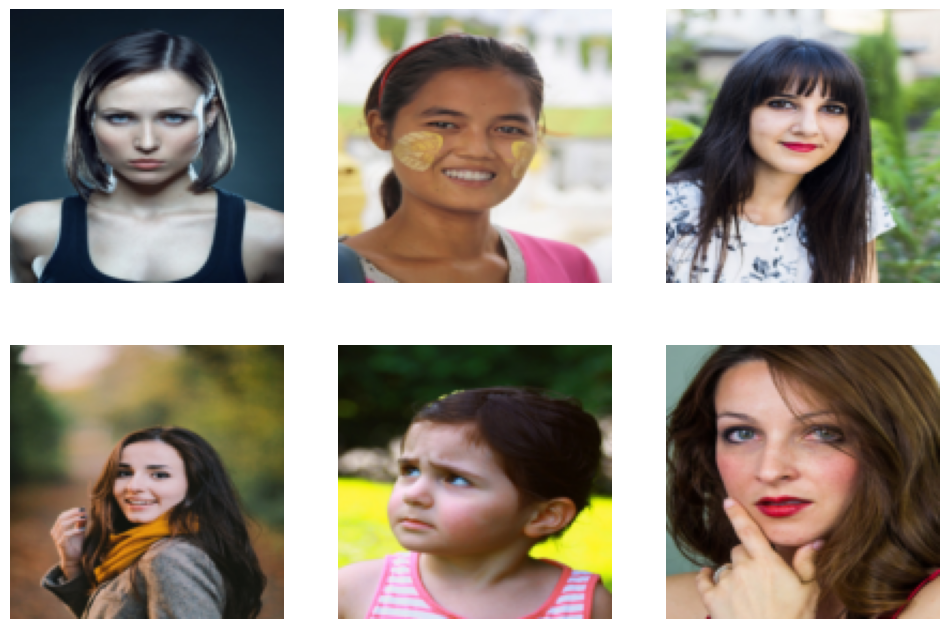

In [15]:
plt.figure(figsize=(12,8)) 
for i in range(6):  
    plt.subplot(2,3,i+1)
    plt.imshow(demo_batch[i].permute(1,2,0).numpy())
    plt.axis('off')

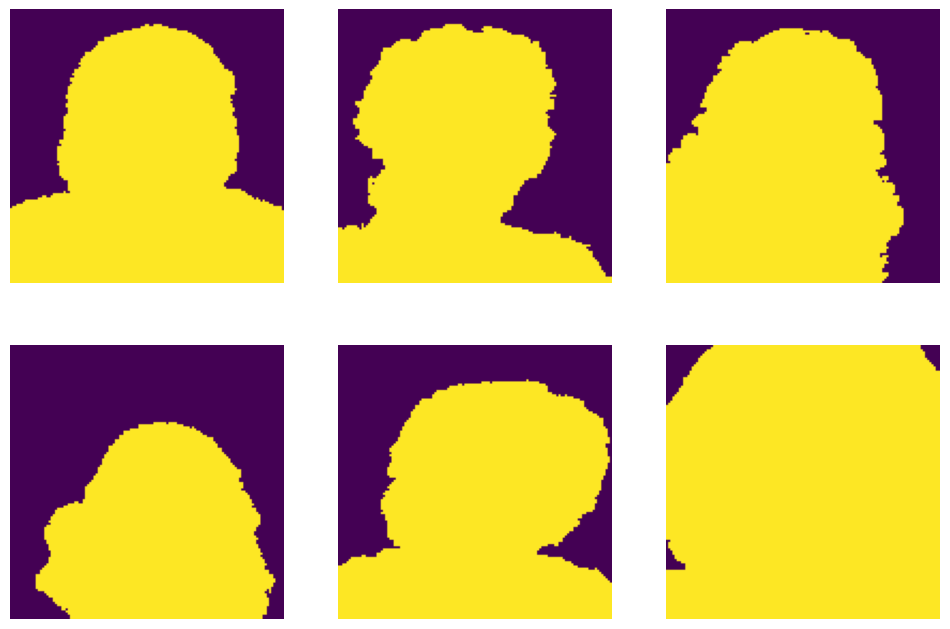

In [16]:
plt.figure(figsize=(12,8)) 
for i in range(6):  
    plt.subplot(2,3,i+1)
    plt.imshow(demo_matte[i].numpy())
    plt.axis('off')

## 编写卷积模块(卷积+BN+激活)

In [17]:
class Convblock(nn.Module):  
    def __init__(self,in_ch,out_ch,k_size=3,st=1,pad=1): 
        super().__init__() 
        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=k_size,stride=st,padding=pad),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True)            
        )
    def forward(self,x): 
        x = self.conv_bn_relu(x) 
        return x
        

$$
\begin{aligned}
H_{new} &= \frac{(H_{old}+2\times 1 - 3)}{1} + 1  \\ 
H_{new}  &=H_{old}+2-3+1\\
H_{new}  &= H_{old}
\end{aligned}
$$

## 编写反卷积模块(反卷积+BN+激活)

In [19]:
class DeConvblock(nn.Module): 
    def __init__(self,in_ch,out_ch,k_size=3,st=2,pad=1,outpad=1):  
        super().__init__()
        self.deconv = \
            nn.ConvTranspose2d(
                in_channels=in_ch,
                out_channels=out_ch, 
                kernel_size=k_size, 
                stride=st, 
                padding=pad, 
                output_padding=outpad
        
            )
      
        self.BN = nn.BatchNorm2d(out_ch)  
       
    def forward(self,x,is_act=True): 
        if is_act:  
            x = torch.relu(self.BN(self.deconv(x)))
        else: #如果不需要激活(即,如果是最后一层输出层,不需要批标准化和激活)
            x = self.deconv(x)  
        return x 
        

$$
\begin{aligned}
H_{new} &= (H_{old} - 1) \times 2 - 2\times1 + 3 + 1 \\ 
H_{new} &= 2H_{old}- 2 - 2 + 4 \\
H_{new} &= 2H_{old}
\end{aligned}
$$

## 编写编码器(四个卷积模块组合在一起)

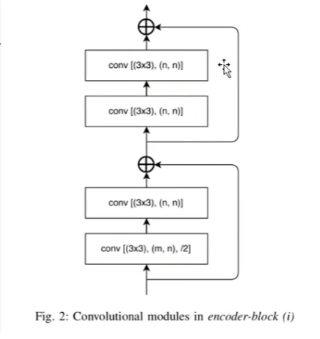

In [20]:
class Encodeblock(nn.Module): 
    def __init__(self,Inch,Outch): 
        super().__init__()  
        self.conv1 = Convblock(Inch,Outch,st=2)  
        self.conv2 = Convblock(Outch,Outch) #没有进行缩放  

        self.conv3 = Convblock(Outch,Outch) 
        self.conv4 = Convblock(Outch,Outch) 

        #定义short_cut链接
        self.short_cut = Convblock(Inch,Outch,st=2)  
        
    def forward(self,x):  
        out1 = self.conv1(x)  
        out1 = self.conv2(out1)  

        shortcut = self.short_cut(x)   

        out2 = self.conv3(out1+shortcut)

        out2 = self.conv4(out2)  

        return out1+out2

## 编写解码器(顺序结构,卷积+反卷积+卷积)

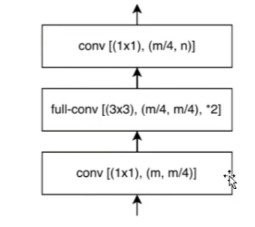

In [34]:
class Decodeblock(nn.Module):  
    def __init__(self,Inch,Outch):   
        super().__init__() 
        self.conv1 = Convblock(Inch,Inch//4,k_size=1,pad=0)
        self.deconv = DeConvblock(Inch//4,Inch//4)  
        self.conv2 = Convblock(Inch//4,Outch,k_size=1,pad=0)  
    def forward(self,x):  
        x =self.conv1(x)  
        x = self.deconv(x) 
        x = self.conv2(x)  

        return x 
        

## 实现整体的网络结构

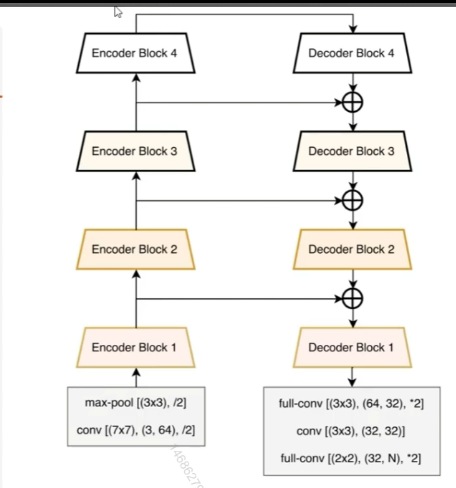

In [35]:
class Linknet(nn.Module):  
    def __init__(self):  
        super().__init__()  
        self.inputconv = Convblock(in_ch=3,out_ch=64,k_size=7,st=2,pad=3) 

        self.maxpool = nn.MaxPool2d(kernel_size=2) #对图像进行一次缩放

        self.enco1 = Encodeblock(64,64)  
        self.enco2 = Encodeblock(64,128)  
        self.enco3 = Encodeblock(128,256)  
        self.enco4 = Encodeblock(256,512)   

        self.deco4 = Decodeblock(512,256)  
        self.deco3 = Decodeblock(256,128)  
        self.deco2 = Decodeblock(128,64)  
        self.deco1 = Decodeblock(64,64)  

        self.outputdeconv = DeConvblock(64,32) 
        self.outputconv = Convblock(32,32)  
        self.outputfullconv = DeConvblock(32,2,k_size=2,pad=0,outpad=0)  
 
    def forward(self,x): 

        x = self.inputconv(x)  
        x = self.maxpool(x)  

        e1 = self.enco1(x)  
        e2 = self.enco2(e1)  
        e3 = self.enco3(e2) 
        e4 = self.enco4(e3)

        d4 = self.deco4(e4)  
        d4 = e3+d4  
        
        d3 = self.deco3(d4)  
        d3 = d3+e2  

        d2 = self.deco2(d3)  
        d2 = d2+e1  

        d1 = self.deco1(d2)  
        
        out1 = self.outputdeconv(d1)  
        out2 = self.outputconv(out1)  
        out_final = self.outputfullconv(out2)

        return out_final

In [36]:
model = Linknet()  

In [37]:
model

Linknet(
  (inputconv): Convblock(
    (conv_bn_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enco1): Encodeblock(
    (conv1): Convblock(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv2): Convblock(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (conv3): Convblock(
      (conv_bn_relu): Sequential(
    

In [38]:
loss_fn = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [41]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    epochIoU=[]
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.numel() #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()
            intersection = torch.logical_and(y,y_pred) #计算原始matte数据和预测matte数据的交集
            union = torch.logical_or(y,y_pred)  #计算并集      
            batch_iou_train = torch.true_divide(
                torch.sum(intersection), 
                torch.sum(union)
            )  #求出批次的iou 
            epochIoU.append(batch_iou_train.cpu().numpy())
        
    epoch_acc = correct/total #因为对比的是像素的iou
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             #注意这里有变化
             
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.numel() #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f} | IoU_avg:{np.mean(epochIoU):.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc,batch_iou_train


In [42]:

from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epoch_IOU_train = []  #创建一个列表,记录每个轮次的交并比
# epoch_IOU_test = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc,batch_iou_train = fit_gpu(
        Train_DL=train_dl,
        TST_DL=test_dl,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = tstepoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    epoch_IOU_train.append(batch_iou_train)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.022 | acc:0.223 | tstloss:0.022 | tstacc:0.222 | IoU_avg:0.842
Epoch 1: 学习率已更新为 1.00e-03
epoch:1 | loss:0.019 | acc:0.228 | tstloss:0.019 | tstacc:0.228 | IoU_avg:0.871
Epoch 2: 学习率已更新为 1.00e-03
epoch:2 | loss:0.016 | acc:0.233 | tstloss:0.016 | tstacc:0.233 | IoU_avg:0.897
Epoch 3: 学习率已更新为 1.00e-03
epoch:3 | loss:0.015 | acc:0.235 | tstloss:0.016 | tstacc:0.232 | IoU_avg:0.908
Epoch 4: 学习率已更新为 1.00e-03
epoch:4 | loss:0.014 | acc:0.236 | tstloss:0.016 | tstacc:0.228 | IoU_avg:0.917
Epoch 5: 学习率已更新为 9.00e-04
epoch:5 | loss:0.013 | acc:0.237 | tstloss:0.015 | tstacc:0.230 | IoU_avg:0.921
Epoch 6: 学习率已更新为 9.00e-04
epoch:6 | loss:0.011 | acc:0.238 | tstloss:0.013 | tstacc:0.235 | IoU_avg:0.929
Epoch 7: 学习率已更新为 9.00e-04
epoch:7 | loss:0.010 | acc:0.240 | tstloss:0.012 | tstacc:0.236 | IoU_avg:0.940
Epoch 8: 学习率已更新为 9.00e-04
epoch:8 | loss:0.010 | acc:0.240 | tstloss:0.012 | tstacc:0.236 | IoU_avg:0.941
Epoch 9: 学习率已更新为 9.00e-04
epoch:9 | loss:0.009 | acc:0.241 | tstloss:0.0

In [46]:
model.eval()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model.to(device)  
example_input = torch.rand(1,3,128,128).to(device)  
traced_model = torch.jit.trace(model,example_input)  

traced_model.save('./model/lknet.pt')

In [48]:
img_batch,mask_batch = next(iter(test_dl))

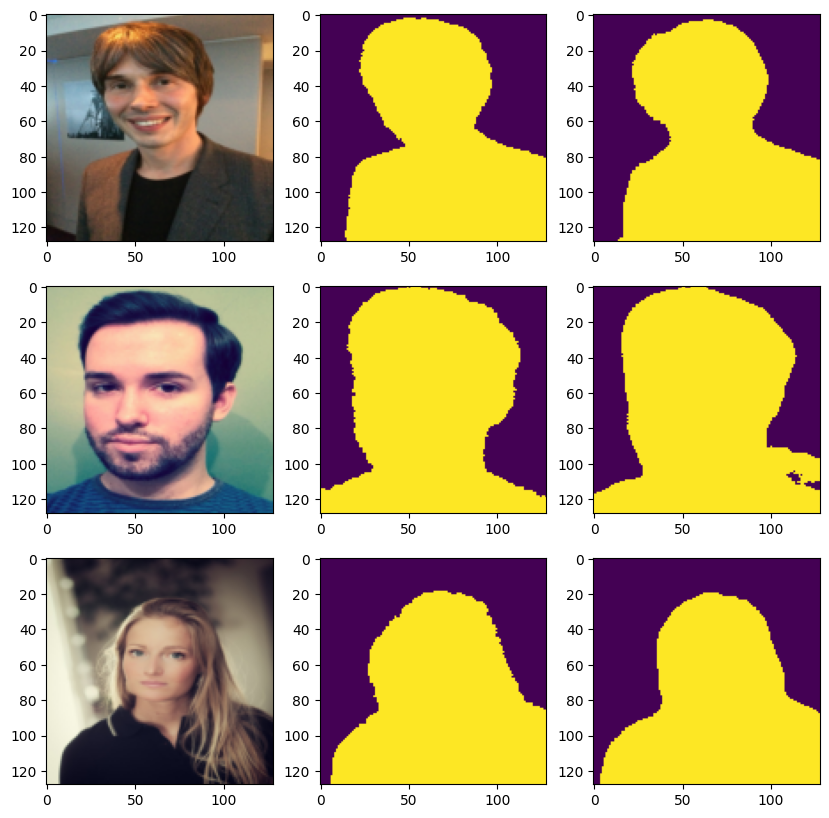

In [49]:
# 假设模型已经在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel = model.to(device)
# 将输入数据也移到相同的设备上
img_batch = img_batch.to(device)
pred_batch = mymodel(img_batch)
plt.figure(figsize=(10,10))  
num=3
for i in range(num):  
    plt.subplot(3,3,i*num+1) 
    plt.imshow(img_batch[i].permute(1,2,0).cpu().numpy())  
    plt.subplot(3,3,i*num+2)   
    plt.imshow(mask_batch[i].cpu().numpy()) 
    plt.subplot(3,3,i*num+3)  
    pred_pic = torch.argmax(pred_batch[i].permute(1,2,0),axis=-1).detach().cpu().numpy()
    plt.imshow(pred_pic)
    

In [59]:
test_pic = Image.open('ngzk.png')
pic_tensor = transform_all(test_pic)  

In [60]:
pic_tensor.shape

torch.Size([4, 128, 128])

In [61]:
img_tensor_b = torch.unsqueeze(pic_tensor,0)
img_tensor_b.shape

torch.Size([1, 4, 128, 128])

In [62]:
img_tensor_b = img_tensor_b[:, :3, :, :] 

In [63]:
img_tensor_b.shape

torch.Size([1, 3, 128, 128])

In [64]:
lkmodel = torch.jit.load('./model/lknet.pt') 
lkmodel.to(device)

RecursiveScriptModule(
  original_name=Linknet
  (inputconv): RecursiveScriptModule(
    original_name=Convblock
    (conv_bn_relu): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU)
    )
  )
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (enco1): RecursiveScriptModule(
    original_name=Encodeblock
    (conv1): RecursiveScriptModule(
      original_name=Convblock
      (conv_bn_relu): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU)
      )
    )
    (conv2): RecursiveScriptModule(
      original_name=Convblock
      (conv_bn_relu): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(

In [65]:
model.to(device)
img_tensor_b=img_tensor_b.to(device)
pred = lkmodel(img_tensor_b)

In [66]:
pred.shape

torch.Size([1, 2, 128, 128])

In [69]:
pred_pic = torch.argmax(pred[0].permute(1,2,0),axis=-1).detach().cpu().numpy()

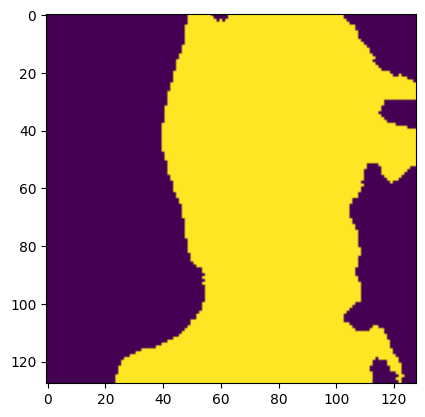

In [71]:
plt.imshow(pred_pic)

(-0.5, 127.5, 127.5, -0.5)

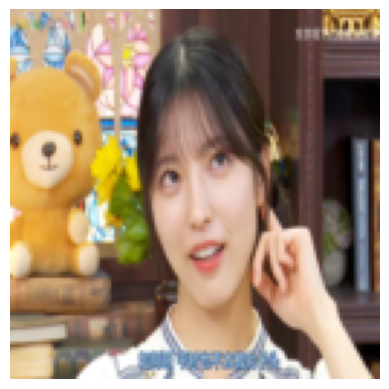

In [72]:
plt.imshow(img_tensor_b[0].permute(1,2,0).cpu().numpy())
plt.axis('off')